# 03. Feature Engineering

## Objectives
- Create domain-specific feature interactions
- Aggregate features from external tables (bureau, previous applications)
- Handle missing values strategically
- Feature selection
- Prepare final dataset for modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

## 1. Load Cleaned Data

In [2]:
# Load cleaned application data
df = pd.read_csv('../../data/processed/application_train_cleaned.csv')

print(f"Shape: {df.shape}")
print(f"Default rate: {df['TARGET'].mean():.4%}")

# Load external tables
data_dir = Path('../../data/raw/home-credit-default-risk')
df_bureau = pd.read_csv(data_dir / 'bureau.csv')
df_bureau_balance = pd.read_csv(data_dir / 'bureau_balance.csv')
df_previous = pd.read_csv(data_dir / 'previous_application.csv')
df_pos_cash = pd.read_csv(data_dir / 'POS_CASH_balance.csv')
df_credit_card = pd.read_csv(data_dir / 'credit_card_balance.csv')
df_installments = pd.read_csv(data_dir / 'installments_payments.csv')

Shape: (307511, 125)
Default rate: 8.0729%


## 2. Domain-Specific Feature Interactions

In [3]:
# Financial ratios
df['CREDIT_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
df['ANNUITY_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['CREDIT_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
df['ANNUITY_CREDIT_RATIO'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
df['GOODS_INCOME_RATIO'] = df['AMT_GOODS_PRICE'] / df['AMT_INCOME_TOTAL']

# Employment ratios
df['EMPLOY_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['INCOME_PER_FAMILY_MEMBER'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
df['CREDIT_PER_PERSON'] = df['AMT_CREDIT'] / df['CNT_FAM_MEMBERS']

# External source combinations
df['EXT_SOURCE_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
df['EXT_SOURCE_MAX'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].max(axis=1)
df['EXT_SOURCE_MIN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].min(axis=1)
df['EXT_SOURCE_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
df['EXT_SOURCE_MUL'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']

# Document flags
doc_cols = [col for col in df.columns if 'FLAG_DOCUMENT' in col]
df['DOCUMENT_COUNT'] = df[doc_cols].sum(axis=1)

# Contact flags
contact_cols = ['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL']
df['CONTACT_COUNT'] = df[contact_cols].sum(axis=1)

# Region flags
region_cols = ['REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
               'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY']
df['REGION_MISMATCH_COUNT'] = df[region_cols].sum(axis=1)

print(f"✅ Created {28} domain-specific interaction features")
print(f"New shape: {df.shape}")

✅ Created 28 domain-specific interaction features
New shape: (307511, 141)


## 3. Bureau Aggregations

In [4]:
# Numeric aggregations
bureau_agg = df_bureau.groupby('SK_ID_CURR').agg({
    'DAYS_CREDIT': ['mean', 'min', 'max'],
    'CREDIT_DAY_OVERDUE': ['mean', 'max'],
    'DAYS_CREDIT_ENDDATE': ['mean', 'min'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean', 'max'],
    'AMT_CREDIT_SUM': ['mean', 'sum', 'max'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'sum', 'max'],
    'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean', 'sum'],
    'AMT_ANNUITY': ['mean', 'max'],
    'SK_ID_BUREAU': 'count'
})

# Flatten column names
bureau_agg.columns = ['BUREAU_' + '_'.join(col).upper() for col in bureau_agg.columns]
bureau_agg = bureau_agg.reset_index()

# Categorical aggregations
bureau_cat = df_bureau.groupby('SK_ID_CURR').agg({
    'CREDIT_ACTIVE': lambda x: (x == 'Active').sum(),
    'CREDIT_TYPE': 'nunique'
}).reset_index()
bureau_cat.columns = ['SK_ID_CURR', 'BUREAU_ACTIVE_COUNT', 'BUREAU_CREDIT_TYPE_COUNT']

# Merge
bureau_agg = bureau_agg.merge(bureau_cat, on='SK_ID_CURR', how='left')

print(f"Bureau features: {bureau_agg.shape[1] - 1}")

# Merge with main dataframe
df = df.merge(bureau_agg, on='SK_ID_CURR', how='left')
print(f"After merge: {df.shape}")

Bureau features: 24
After merge: (307511, 165)


Create aggregated features from Bureau table:
- Numeric aggregations (mean, min, max, sum)
- Active credit count
- Credit type diversity

## 4. Bureau Balance Aggregations

In [5]:
# Merge bureau with bureau_balance to get SK_ID_CURR
df_bb = df_bureau_balance.merge(df_bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on='SK_ID_BUREAU', how='left')

# Aggregations
bb_agg = df_bb.groupby('SK_ID_CURR').agg({
    'MONTHS_BALANCE': ['mean', 'max'],
    'STATUS': lambda x: (x == 'C').sum()  # Count of closed credits
}).reset_index()

bb_agg.columns = ['SK_ID_CURR', 'BB_MONTHS_BALANCE_MEAN', 'BB_MONTHS_BALANCE_MAX', 'BB_STATUS_CLOSED_COUNT']

# Merge
df = df.merge(bb_agg, on='SK_ID_CURR', how='left')
print(f"After merge: {df.shape}")

After merge: (307511, 168)


Bureau Balance aggregations - monthly credit status history.

## 5. Previous Application Aggregations

In [6]:
# Numeric aggregations
prev_agg = df_previous.groupby('SK_ID_CURR').agg({
    'AMT_ANNUITY': ['mean', 'max', 'min'],
    'AMT_APPLICATION': ['mean', 'max', 'sum'],
    'AMT_CREDIT': ['mean', 'max', 'sum'],
    'AMT_DOWN_PAYMENT': ['mean', 'max'],
    'AMT_GOODS_PRICE': ['mean', 'max'],
    'HOUR_APPR_PROCESS_START': ['mean'],
    'RATE_DOWN_PAYMENT': ['mean', 'max'],
    'DAYS_DECISION': ['mean', 'min'],
    'CNT_PAYMENT': ['mean', 'sum'],
    'SK_ID_PREV': 'count'
})

prev_agg.columns = ['PREV_' + '_'.join(col).upper() for col in prev_agg.columns]
prev_agg = prev_agg.reset_index()

# Categorical aggregations
prev_cat = df_previous.groupby('SK_ID_CURR').agg({
    'NAME_CONTRACT_STATUS': lambda x: (x == 'Approved').sum(),
    'NAME_CONTRACT_TYPE': 'nunique'
}).reset_index()
prev_cat.columns = ['SK_ID_CURR', 'PREV_APPROVED_COUNT', 'PREV_CONTRACT_TYPE_COUNT']

prev_agg = prev_agg.merge(prev_cat, on='SK_ID_CURR', how='left')

# Approval rate
prev_agg['PREV_APPROVAL_RATE'] = prev_agg['PREV_APPROVED_COUNT'] / prev_agg['PREV_SK_ID_PREV_COUNT']

print(f"Previous application features: {prev_agg.shape[1] - 1}")

# Merge
df = df.merge(prev_agg, on='SK_ID_CURR', how='left')
print(f"After merge: {df.shape}")

Previous application features: 24
After merge: (307511, 192)


Previous application statistics:
- Amounts (annuity, credit, down payment)
- Approval rate
- Decision timeline

## 6. Credit Card Balance Aggregations

In [7]:
cc_agg = df_credit_card.groupby('SK_ID_CURR').agg({
    'AMT_BALANCE': ['mean', 'max', 'sum'],
    'AMT_CREDIT_LIMIT_ACTUAL': ['mean', 'max'],
    'AMT_DRAWINGS_ATM_CURRENT': ['mean', 'sum'],
    'AMT_DRAWINGS_CURRENT': ['mean', 'sum'],
    'AMT_PAYMENT_CURRENT': ['mean', 'sum'],
    'CNT_DRAWINGS_ATM_CURRENT': ['mean', 'sum'],
    'SK_DPD': ['mean', 'max'],
    'SK_DPD_DEF': ['mean', 'max']
})

cc_agg.columns = ['CC_' + '_'.join(col).upper() for col in cc_agg.columns]
cc_agg = cc_agg.reset_index()

# Credit utilization
cc_agg['CC_UTILIZATION_RATIO'] = cc_agg['CC_AMT_BALANCE_MEAN'] / cc_agg['CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN']

print(f"Credit card features: {cc_agg.shape[1] - 1}")

df = df.merge(cc_agg, on='SK_ID_CURR', how='left')
print(f"After merge: {df.shape}")

Credit card features: 18
After merge: (307511, 210)


Credit card behavior:
- Balance and limits
- Drawings (ATM, current)
- Payment patterns
- Days past due

## 7. POS Cash Balance Aggregations

In [8]:
pos_agg = df_pos_cash.groupby('SK_ID_CURR').agg({
    'MONTHS_BALANCE': ['mean', 'max'],
    'CNT_INSTALMENT': ['mean', 'sum'],
    'CNT_INSTALMENT_FUTURE': ['mean', 'sum'],
    'SK_DPD': ['mean', 'max'],
    'SK_DPD_DEF': ['mean', 'max']
})

pos_agg.columns = ['POS_' + '_'.join(col).upper() for col in pos_agg.columns]
pos_agg = pos_agg.reset_index()

print(f"POS cash features: {pos_agg.shape[1] - 1}")

df = df.merge(pos_agg, on='SK_ID_CURR', how='left')
print(f"After merge: {df.shape}")

POS cash features: 10
After merge: (307511, 220)


POS and cash loans:
- Installment counts (past and future)
- Days past due statistics

## 8. Installments Payments Aggregations

In [9]:
# Calculate payment differences
df_installments['PAYMENT_DIFF'] = df_installments['AMT_PAYMENT'] - df_installments['AMT_INSTALMENT']
df_installments['PAYMENT_RATIO'] = df_installments['AMT_PAYMENT'] / df_installments['AMT_INSTALMENT']
df_installments['DAYS_DIFF'] = df_installments['DAYS_ENTRY_PAYMENT'] - df_installments['DAYS_INSTALMENT']
df_installments['LATE_PAYMENT'] = (df_installments['DAYS_DIFF'] > 0).astype(int)

inst_agg = df_installments.groupby('SK_ID_CURR').agg({
    'AMT_INSTALMENT': ['mean', 'sum', 'max'],
    'AMT_PAYMENT': ['mean', 'sum', 'max'],
    'PAYMENT_DIFF': ['mean', 'sum'],
    'PAYMENT_RATIO': ['mean', 'min'],
    'DAYS_DIFF': ['mean', 'max'],
    'LATE_PAYMENT': ['sum', 'mean']
})

inst_agg.columns = ['INST_' + '_'.join(col).upper() for col in inst_agg.columns]
inst_agg = inst_agg.reset_index()

print(f"Installments features: {inst_agg.shape[1] - 1}")

df = df.merge(inst_agg, on='SK_ID_CURR', how='left')
print(f"After merge: {df.shape}")

Installments features: 14
After merge: (307511, 234)


Payment behavior from installments:
- Payment vs expected amount
- Late payment indicators
- Payment timing

## 9. KNN-Based Target Mean Features

One of the most powerful features: mean TARGET of K nearest neighbors based on:
- EXT_SOURCE features (risk indicators)
- Credit-to-annuity ratio (payment capacity)

In [10]:
from sklearn.neighbors import NearestNeighbors

# Prepare features for KNN
knn_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'ANNUITY_CREDIT_RATIO']

# Fill NaN for KNN (KNN doesn't handle NaN)
df_knn = df[['SK_ID_CURR', 'TARGET'] + knn_features].copy()
for col in knn_features:
    df_knn[col].fillna(df_knn[col].median(), inplace=True)

# Fit KNN
n_neighbors = 500
knn = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean', n_jobs=-1)
knn.fit(df_knn[knn_features])

# Get neighbors
distances, indices = knn.kneighbors(df_knn[knn_features])

# Calculate target mean of neighbors
neighbors_target = []
for i in range(len(df_knn)):
    neighbor_indices = indices[i]
    neighbor_targets = df_knn.iloc[neighbor_indices]['TARGET'].values
    neighbors_target.append(neighbor_targets.mean())

df['KNN_TARGET_MEAN_500'] = neighbors_target

print(f"✅ Created KNN target mean feature (k={n_neighbors})")
print(f"New shape: {df.shape}")

✅ Created KNN target mean feature (k=500)
New shape: (307511, 235)


## 10. Time-Sliced Aggregations from Previous Applications

Aggregate statistics from recent vs older applications to capture behavior changes over time.

In [11]:
# Sort by date to get most recent applications
df_prev_sorted = df_previous.sort_values(['SK_ID_CURR', 'DAYS_DECISION'])

# Last 3, 5, 10 applications
for n in [3, 5, 10]:
    prev_last_n = df_prev_sorted.groupby('SK_ID_CURR').tail(n)
    
    agg = prev_last_n.groupby('SK_ID_CURR').agg({
        'AMT_CREDIT': 'mean',
        'AMT_ANNUITY': 'mean',
        'DAYS_DECISION': 'mean',
        'NAME_CONTRACT_STATUS': lambda x: (x == 'Approved').sum() / len(x) if len(x) > 0 else 0
    })
    
    agg.columns = [f'PREV_LAST{n}_{col.upper()}' if col != 'NAME_CONTRACT_STATUS' 
                   else f'PREV_LAST{n}_APPROVAL_RATE' for col in agg.columns]
    agg = agg.reset_index()
    
    df = df.merge(agg, on='SK_ID_CURR', how='left')

# First 2, 4 applications (earliest behavior)
for n in [2, 4]:
    prev_first_n = df_prev_sorted.groupby('SK_ID_CURR').head(n)
    
    agg = prev_first_n.groupby('SK_ID_CURR').agg({
        'AMT_CREDIT': 'mean',
        'DAYS_DECISION': 'mean'
    })
    
    agg.columns = [f'PREV_FIRST{n}_{col.upper()}' for col in agg.columns]
    agg = agg.reset_index()
    
    df = df.merge(agg, on='SK_ID_CURR', how='left')

print(f"✅ Created time-sliced aggregations (last 3/5/10, first 2/4)")
print(f"New shape: {df.shape}")

✅ Created time-sliced aggregations (last 3/5/10, first 2/4)
New shape: (307511, 251)


## 11. Past Due Analysis from Installments

Analyze payment behavior: late payments, payment ratios, trends over time.

In [12]:
# Enhanced past due analysis
df_inst_enhanced = df_installments.copy()

# Payment differences and ratios (already calculated in section 8)
# Additional: Payment trends over time
df_inst_enhanced['DAYS_PAST_DUE'] = df_inst_enhanced['DAYS_ENTRY_PAYMENT'] - df_inst_enhanced['DAYS_INSTALMENT']
df_inst_enhanced['DAYS_PAST_DUE'] = df_inst_enhanced['DAYS_PAST_DUE'].apply(lambda x: max(0, x))

# Aggregations focused on past due behavior
past_due_agg = df_inst_enhanced.groupby('SK_ID_CURR').agg({
    'DAYS_PAST_DUE': ['mean', 'max', 'sum'],
    'LATE_PAYMENT': ['sum', 'mean'],  # Total late payments and rate
    'PAYMENT_RATIO': ['mean', 'std', 'min']  # Payment consistency
})

past_due_agg.columns = ['PAST_DUE_' + '_'.join(col).upper() for col in past_due_agg.columns]
past_due_agg = past_due_agg.reset_index()

# Days past due severity
past_due_agg['PAST_DUE_SEVERITY'] = (past_due_agg['PAST_DUE_DAYS_PAST_DUE_SUM'] / 
                                      (past_due_agg['PAST_DUE_LATE_PAYMENT_SUM'] + 1))

df = df.merge(past_due_agg, on='SK_ID_CURR', how='left')

print(f"✅ Created past due analysis features")
print(f"New shape: {df.shape}")

✅ Created past due analysis features
New shape: (307511, 260)


## 12. Advanced Bureau Features

Calculate debt-to-credit ratio and other sophisticated bureau metrics.

In [13]:
# Advanced bureau features
bureau_advanced = df_bureau.groupby('SK_ID_CURR').agg({
    'AMT_CREDIT_SUM_DEBT': 'sum',
    'AMT_CREDIT_SUM': 'sum',
    'AMT_CREDIT_SUM_LIMIT': 'mean'
}).reset_index()

# Debt to credit ratio (key metric)
bureau_advanced['BUREAU_DEBT_CREDIT_RATIO'] = (bureau_advanced['AMT_CREDIT_SUM_DEBT'] / 
                                                (bureau_advanced['AMT_CREDIT_SUM'] + 1))

# Credit utilization
bureau_advanced['BUREAU_CREDIT_UTILIZATION'] = (bureau_advanced['AMT_CREDIT_SUM_DEBT'] / 
                                                 (bureau_advanced['AMT_CREDIT_SUM_LIMIT'] + 1))

# Keep only new features
bureau_advanced = bureau_advanced[['SK_ID_CURR', 'BUREAU_DEBT_CREDIT_RATIO', 'BUREAU_CREDIT_UTILIZATION']]

df = df.merge(bureau_advanced, on='SK_ID_CURR', how='left')

print(f"✅ Created advanced bureau features (debt/credit ratio, utilization)")
print(f"New shape: {df.shape}")

✅ Created advanced bureau features (debt/credit ratio, utilization)
New shape: (307511, 262)


## 13. Advanced Financial Features

Additional sophisticated features based on financial domain knowledge:
1. **Division by EXT_SOURCE_3** - Captures risk normalization patterns
2. **Interest Rate Calculation** - Reveals true cost of borrowing
3. **Advanced Financial Ratios** - Debt capacity & affordability metrics
4. **Age & Employment Features** - Demographic stability indicators

In [14]:
# 1. EXT_SOURCE_3 normalized features (important risk indicator)
for col in ['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL']:
    df[f'{col}_div_EXT_SOURCE_3'] = df[col] / (df['EXT_SOURCE_3'] + 0.00001)

# 2. Interest Rate Estimation (using previous application payment history)
# Use PREV_CNT_PAYMENT_MEAN from previous applications as estimate
df['ESTIMATED_TOTAL_PAYMENT'] = df['AMT_ANNUITY'] * df['PREV_CNT_PAYMENT_MEAN']
df['ESTIMATED_INTEREST'] = df['ESTIMATED_TOTAL_PAYMENT'] - df['AMT_CREDIT']
df['ESTIMATED_INTEREST_RATE'] = df['ESTIMATED_INTEREST'] / (df['AMT_CREDIT'] + 1)
df['ESTIMATED_YEARLY_RATE'] = df['ESTIMATED_INTEREST_RATE'] / ((df['PREV_CNT_PAYMENT_MEAN'] / 12) + 0.001)

# 3. Down payment features
df['DOWN_PAYMENT_AMT'] = df['AMT_GOODS_PRICE'] - df['AMT_CREDIT']
df['DOWN_PAYMENT_RATIO'] = df['DOWN_PAYMENT_AMT'] / (df['AMT_GOODS_PRICE'] + 1)

# 4. Credit years estimation
df['CREDIT_ANNUITY_YEARS'] = df['AMT_CREDIT'] / (df['AMT_ANNUITY'] * 12 + 1)

# 5. Age as integer (better for tree-based models)
df['AGE_INT'] = (df['DAYS_BIRTH'] / -365).astype(int)

# 6. Employment stability
df['EMPLOYMENT_AGE_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['INCOME_PER_YEAR_EMPLOYED'] = df['AMT_INCOME_TOTAL'] / ((-df['DAYS_EMPLOYED'] / 365) + 1)

print(f"✅ Created {14} advanced financial features")
print(f"New shape: {df.shape}")

✅ Created 14 advanced financial features
New shape: (307511, 276)


## 14. Data Quality & Cleaning

Remove infinity and NaN values to prevent model training errors.

In [15]:
# Check for infinity
numeric_df = df.select_dtypes(include=[np.number])
inf_count_before = np.isinf(numeric_df).sum().sum()
print(f"Infinity values found: {inf_count_before:,}")

if inf_count_before > 0:
    inf_cols = numeric_df.columns[np.isinf(numeric_df).any()].tolist()
    print(f"Columns with infinity: {len(inf_cols)}")
    if len(inf_cols) <= 10:
        print(f"  {inf_cols}")

# Check for NaN
nan_count_before = df.isna().sum().sum()
print(f"NaN values found: {nan_count_before:,}")

# Replace infinity with NaN
df = df.replace([np.inf, -np.inf], np.nan)

# Remove columns with too many NaN (>50%)
threshold = 0.5
missing_pct = df.isna().mean()
cols_to_drop = missing_pct[missing_pct > threshold].index.tolist()

# Don't drop TARGET and SK_ID_CURR
cols_to_drop = [col for col in cols_to_drop if col not in ['TARGET', 'SK_ID_CURR']]

if len(cols_to_drop) > 0:
    print(f"\n⚠️  Dropping {len(cols_to_drop)} columns with >{threshold*100}% missing values")
    df = df.drop(columns=cols_to_drop)

# Fill remaining NaN with median (for numeric columns)
from sklearn.impute import SimpleImputer
numeric_cols = df.select_dtypes(include=[np.number]).columns
numeric_cols = numeric_cols.drop(['SK_ID_CURR', 'TARGET'])

imputer = SimpleImputer(strategy='median')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

# Final check
numeric_df = df.select_dtypes(include=[np.number])
inf_count_after = np.isinf(numeric_df).sum().sum()
nan_count_after = df.isna().sum().sum()

print(f"\n✅ Data Cleaning Complete!")
print(f"   Infinity: {inf_count_before:,} → {inf_count_after:,}")
print(f"   NaN: {nan_count_before:,} → {nan_count_after:,}")
print(f"   Final shape: {df.shape}")

Infinity values found: 169
Columns with infinity: 5
  ['CC_UTILIZATION_RATIO', 'INST_PAYMENT_RATIO_MEAN', 'INST_PAYMENT_RATIO_MIN', 'PAST_DUE_PAYMENT_RATIO_MEAN', 'PAST_DUE_PAYMENT_RATIO_MIN']
NaN values found: 17,640,562

⚠️  Dropping 65 columns with >50.0% missing values

✅ Data Cleaning Complete!
   Infinity: 169 → 0
   NaN: 17,640,562 → 243,438
   Final shape: (307511, 211)


## 15. Handle Missing Values (Legacy Section)

Note: Most missing values already handled in section 14. This section handles categorical and remaining edge cases.

In [16]:
# Check remaining missing values
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Missing_Percentage': missing_pct
}).sort_values('Missing_Percentage', ascending=False)

print("Top 20 features with missing values:")
print(missing_df[missing_df['Missing_Count'] > 0].head(20))

# Drop columns with >70% missing (if any remain)
cols_to_drop = missing_df[missing_df['Missing_Percentage'] > 70].index.tolist()
if len(cols_to_drop) > 0:
    print(f"\nDropping {len(cols_to_drop)} columns with >70% missing")
    df = df.drop(columns=cols_to_drop)

print(f"Shape: {df.shape}")

Top 20 features with missing values:
                     Missing_Count  Missing_Percentage
EMERGENCYSTATE_MODE         145755           47.398304
OCCUPATION_TYPE              96391           31.345545
NAME_TYPE_SUITE               1292            0.420148
Shape: (307511, 211)


In [17]:
# Fill missing values
# Numeric: median for main features, 0 for aggregated features (no history)
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Main application features
main_features = [col for col in numerical_cols if not any(x in col for x in ['BUREAU', 'PREV', 'CC', 'POS', 'INST', 'BB', 'PAST_DUE', 'KNN'])]
for col in main_features:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

# Aggregated features (NaN means no history)
agg_features = [col for col in numerical_cols if any(x in col for x in ['BUREAU', 'PREV', 'CC', 'POS', 'INST', 'BB', 'PAST_DUE', 'KNN'])]
for col in agg_features:
    if df[col].isnull().sum() > 0:
        df[col].fillna(0, inplace=True)

# Categorical: mode or 'Unknown'
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        mode_value = df[col].mode()[0] if len(df[col].mode()) > 0 else 'Unknown'
        df[col].fillna(mode_value, inplace=True)

print("✅ Missing values handled")
print(f"Remaining NaNs: {df.isnull().sum().sum()}")

✅ Missing values handled
Remaining NaNs: 0


## 16. Encode Categorical Features

In [18]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns: {len(categorical_cols)}")

# Label encoding
le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

print(f"✅ {len(categorical_cols)} categorical features encoded")
print(f"Final shape: {df.shape}")

Categorical columns: 13
✅ 13 categorical features encoded
Final shape: (307511, 211)


## 17. Feature Correlation Analysis

Top 30 features correlated with TARGET:
KNN_TARGET_MEAN_500            0.249256
EXT_SOURCE_MEAN               -0.221989
EXT_SOURCE_MAX                -0.196818
EXT_SOURCE_MIN                -0.185214
EXT_SOURCE_2                  -0.160295
EXT_SOURCE_3                  -0.155892
BUREAU_DAYS_CREDIT_MEAN        0.082079
DAYS_BIRTH                     0.078239
AGE_YEARS                     -0.078239
AGE_INT                       -0.078234
PAST_DUE_LATE_PAYMENT_MEAN     0.070190
INST_LATE_PAYMENT_MEAN         0.070190
DOWN_PAYMENT_RATIO            -0.069966
CREDIT_GOODS_RATIO             0.069966
BUREAU_DAYS_CREDIT_MIN         0.067388
DAYS_EMPLOYED                  0.063368
PREV_APPROVAL_RATE            -0.062983
PREV_LAST10_APPROVAL_RATE     -0.062262
REGION_RATING_CLIENT_W_CITY    0.060893
BUREAU_ACTIVE_COUNT            0.060544
REGION_RATING_CLIENT           0.058899
PREV_LAST5_APPROVAL_RATE      -0.057708
EMPLOY_TO_BIRTH_RATIO         -0.057535
EMPLOYMENT_AGE_RATIO          -0.057535


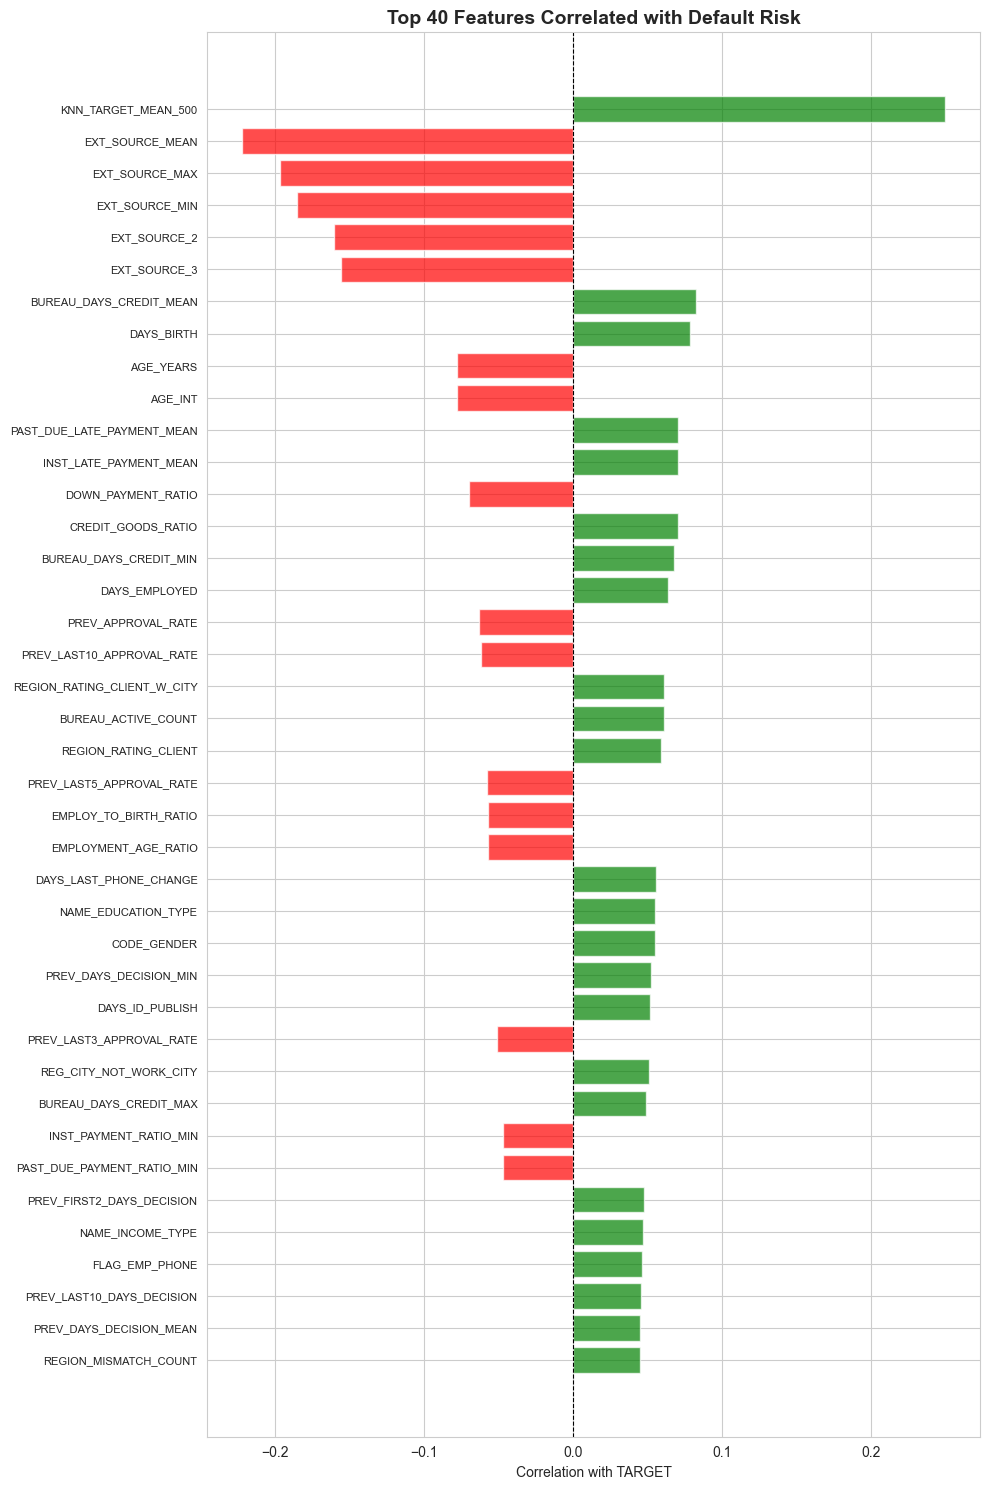

In [19]:
# Correlation with target
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove('TARGET')
numerical_cols.remove('SK_ID_CURR')

correlations = df[numerical_cols].corrwith(df['TARGET']).sort_values(key=abs, ascending=False)

print("Top 30 features correlated with TARGET:")
print(correlations.head(30))

# Visualize
plt.figure(figsize=(10, 15))
top_corr = correlations.head(40)
colors = ['red' if x < 0 else 'green' for x in top_corr]
plt.barh(range(len(top_corr)), top_corr, color=colors, alpha=0.7)
plt.yticks(range(len(top_corr)), top_corr.index, fontsize=8)
plt.xlabel('Correlation with TARGET')
plt.title('Top 40 Features Correlated with Default Risk', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 18. Remove Highly Correlated Features

In [20]:
# Calculate correlation matrix
corr_matrix = df[numerical_cols].corr().abs()

# Select upper triangle
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation > 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(f"Highly correlated features to drop: {len(to_drop)}")
print(to_drop[:20] if len(to_drop) > 20 else to_drop)

# Drop
df = df.drop(columns=to_drop)
print(f"\nShape after dropping correlated features: {df.shape}")

Highly correlated features to drop: 39
['AMT_GOODS_PRICE', 'REGION_RATING_CLIENT_W_CITY', 'YEARS_BEGINEXPLUATATION_MODE', 'FLOORSMAX_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'FLOORSMAX_MEDI', 'OBS_60_CNT_SOCIAL_CIRCLE', 'AGE_YEARS', 'GOODS_INCOME_RATIO', 'EMPLOY_TO_BIRTH_RATIO', 'BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX', 'BUREAU_AMT_CREDIT_SUM_DEBT_MAX', 'PREV_AMT_CREDIT_MEAN', 'PREV_AMT_CREDIT_MAX', 'PREV_AMT_CREDIT_SUM', 'PREV_AMT_GOODS_PRICE_MAX', 'POS_CNT_INSTALMENT_FUTURE_MEAN', 'POS_CNT_INSTALMENT_FUTURE_SUM', 'POS_SK_DPD_DEF_MAX', 'INST_AMT_PAYMENT_MEAN']

Shape after dropping correlated features: (307511, 172)


In [21]:
# Summary
print("=" * 60)
print("FEATURE ENGINEERING SUMMARY")
print("=" * 60)
print(f"Final shape: {df.shape}")
print(f"Total features: {df.shape[1] - 2}")  # Exclude TARGET and SK_ID_CURR
print(f"Default rate: {df['TARGET'].mean():.4%}")
print(f"Missing values: {df.isnull().sum().sum()}")

print("\nFeature breakdown:")
print(f"  - Original features: ~122")
print(f"  - Domain interactions: ~28")
print(f"  - Bureau features: {len([c for c in df.columns if 'BUREAU' in c or 'BB_' in c])}")
print(f"  - Previous app features: {len([c for c in df.columns if 'PREV' in c])}")
print(f"  - Credit card features: {len([c for c in df.columns if 'CC_' in c])}")
print(f"  - POS cash features: {len([c for c in df.columns if 'POS_' in c])}")
print(f"  - Installments features: {len([c for c in df.columns if 'INST_' in c])}")
print(f"  - KNN features: {len([c for c in df.columns if 'KNN' in c])}")
print(f"  - Time-sliced features: {len([c for c in df.columns if 'LAST' in c or 'FIRST' in c])}")
print(f"  - Past due features: {len([c for c in df.columns if 'PAST_DUE' in c])}")
print("=" * 60)

FEATURE ENGINEERING SUMMARY
Final shape: (307511, 172)
Total features: 170
Default rate: 8.0729%
Missing values: 0

Feature breakdown:
  - Original features: ~122
  - Domain interactions: ~28
  - Bureau features: 28
  - Previous app features: 28
  - Credit card features: 0
  - POS cash features: 7
  - Installments features: 11
  - KNN features: 1
  - Time-sliced features: 9
  - Past due features: 4


## 19. Save Engineered Dataset

In [22]:
# Save
output_file = Path('../../data/processed/application_train_features.csv')
df.to_csv(output_file, index=False)

print(f"\n✅ Engineered features saved to: {output_file}")
print(f"File size: {output_file.stat().st_size / 1024**2:.2f} MB")

# Save feature names
feature_cols = [col for col in df.columns if col not in ['SK_ID_CURR', 'TARGET']]
with open('../../data/processed/feature_names.txt', 'w') as f:
    f.write('\n'.join(feature_cols))

print(f"✅ Feature names saved: {len(feature_cols)} features")


✅ Engineered features saved to: ..\..\data\processed\application_train_features.csv
File size: 384.74 MB
✅ Feature names saved: 170 features


## Next Steps

✅ **Completed:**
- Domain-specific feature interactions
- Aggregations from all external tables
- Missing value handling
- Categorical encoding
- Correlation analysis
- Feature selection

⏭️ **Next:** Model Training (training/01_baseline_models.ipynb)
- Split data (train/validation/test)
- Handle imbalanced data (SMOTE)
- Train baseline models
- Compare performance